In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [0]:
item_cats= pd.read_csv('item_categories.csv')
items= pd.read_csv('items.csv')
train= pd.read_csv('sales_train_v2.csv')
shops= pd.read_csv('shops.csv')
test= pd.read_csv('test.csv')


In [0]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [0]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [0]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [0]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [0]:
import datetime

In [0]:
train.date = train.date.apply(lambda x:datetime.datetime.strptime(x,'%d.%m.%Y') )
train.head()

In [0]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline


In [0]:
print ('number of shops: ', train['shop_id'].max())
print ('number of items: ', train['item_id'].max())
num_month = train['date_block_num'].max()
print ('number of month: ', num_month)
print ('size of train: ', train.shape)
train.head()

number of shops:  59
number of items:  22169
number of month:  33
size of train:  (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


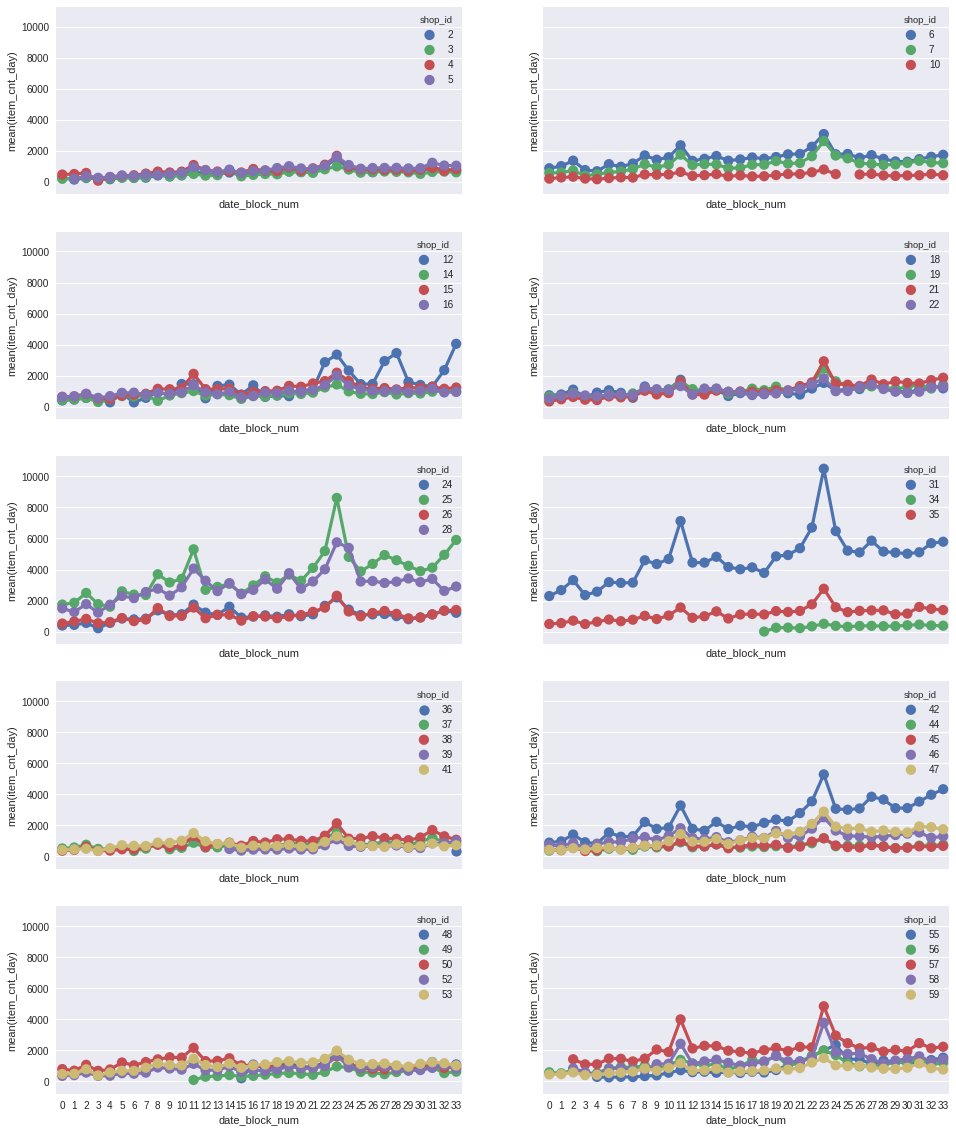

In [0]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

In [0]:
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train= train.drop('date', axis=1)

In [0]:
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,0,59,22154,999.00,1.0,1,2013
1,0,25,2552,899.00,1.0,1,2013
2,0,25,2552,899.00,-1.0,1,2013
3,0,25,2554,1709.05,1.0,1,2013
4,0,25,2555,1099.00,1.0,1,2013


In [0]:
train = train.groupby([c for c in train.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})

#Monthly Mean
shop_item_monthly_mean = train[['shop_id','item_id','item_cnt_month']].groupby(['shop_id','item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})

In [0]:
#Items features
train = pd.merge(train, items, how='left', on='item_id')

#Item Category features
train = pd.merge(train, item_cats, how='left', on='item_category_id')

#Shops features
train = pd.merge(train, shops, how='left', on='shop_id')
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,item_name,item_category_id,item_category_name,shop_name
0,0,59,22154,999.00,1.0,1,2013,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,0,25,2552,899.00,1.0,1,2013,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,0,25,2552,899.00,-1.0,1,2013,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,0,25,2554,1709.05,1.0,1,2013,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,0,25,2555,1099.00,1.0,1,2013,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [0]:
#Items features
test = pd.merge(test, items, how='left', on='item_id')

#Item Category features
test = pd.merge(test, item_cats, how='left', on='item_category_id')

#Shops features
test = pd.merge(test, shops, how='left', on='shop_id')
test.head()

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад"""
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад"""
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад"""
